In [1]:
import sys
from pathlib import Path, PureWindowsPath
current_folder = PureWindowsPath(globals()['_dh'][0]).as_posix()
path_root = "/".join(current_folder.split("/")[:-3]) #remonter au dossier root du projet
os.chdir(path_root)
print(os.getcwd())
sys.path.append(os.getcwd() + "/sources/classification/")

c:\Users\eupho\OneDrive\Documents\perso\projets\classification_texte_bapteme_philo


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, cross_val_score 
from gensim.utils import tokenize
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from pathlib import Path, PureWindowsPath
from lib_classification import *
pd.set_option('display.max_colwidth', 30)
pd.set_option('display.min_rows', 5)
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_colwidth', None) #afficher texte entier dans dataframe

In [3]:
path = PureWindowsPath(os.getcwd() + "/data/input/data_philosophy_baptism.parquet")
path = path.as_posix() #convertir en path linux (convertir les \\ en /)
corpus = pd.read_parquet(path) #engine="fastparquet"
corpus = get_balanced_binary_dataset(corpus, class_col_name="category")

print(corpus["category_bin"].value_counts())
print("presence de doublons ?")
print(corpus.id.duplicated().any())
print(corpus.index.duplicated().any())
corpus

1    1833
0    1833
Name: category_bin, dtype: int64
presence de doublons ?
False
False


id  \
0        0   
1        1   
...    ...   
3664  3664   
3665  3665   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   message  \
0     > Si la Bienheureuse Vierge avait √©t√© sanctifi√©e, de quelque mani√®re que ce > f√ªt, avant son animation, elle n‚Äôaurait jamais encouru la tache de la faute > originelle. Ainsi elle n‚Äôaurait pas eu besoin de la r√©demption et du salut > apport√©s par le Christ, dont il est dit en S. Matthieu (1, 21) : ¬´ Il > sauvera son peuple de ses p√©ch√©s. ¬ª Or il est inadmissible que le Christ ne > soit pas ¬ª le sauveur de tous les hommes ¬ª (1 Tm 4, 10). Il reste donc que > la sanctification de la Bienheureuse Vierge Marie s‚Äôest accomplie apr√®s son > animation.   
1                                                                                                                                                                                                                                                                                                                                                                                                                               [Kline on the Works Principle in the Mosaic economy ‚Äì Lee Irons](http://www.upper-register.com/papers/works-principle-mosaic- economy.pdf)   
...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    ...   
3664                                                                                                                                                                                                                                                                                                                                                                                                                                                                            En langage thomiste on dira: ¬´ Dieu n‚Äôest pas une composition de genre et de diff√©rence ¬ª.   
3665                                                                                                          Vous qui √™tes en m√©decine, vous devriez savoir, que c‚Äôest en moyenne (c‚Äôest une moyenne, pour certains avant, et pour d‚Äôautres apr√®s. Comme pour tout nous sommes diff√©rents) √† partir de 7 ans que l‚Äôenfant commence √† faire la diff√©rence entre le bien et le mal. Qu‚Äôil commence √† reconna√Ætre dans ses actions, paroles, gr√¢ce √† la r√©ponse que l‚Äôautre lui donne si ce qu‚Äôil fait, ou dit est bien ou mal. Avant cela il n‚Äôen avait aucunes conscience.   

                                                                                                                                                                                                                                                                                                               message_preprocessed  \
0     si bienheureux vierge sanctifi√©e quelque mani√®re avant animation jamais encouru tache faute originelle ainsi besoin r√©demption salut apport√©s christ dont dit matthieu ¬´ sauvera peup

In [4]:
tokens = corpus["message_preprocessed"].apply(word_tokenize)
model_skip_gram = Word2Vec(sentences=tokens, vector_size=200,workers=-1, sg=0) #modele cbow
model = model_skip_gram

Utilisation des features word2vec pour la classification

Creation features du modele : moyenne des "mots" d'une phrase

In [5]:
words_vectors_skip_gram = model_skip_gram.wv
vocab = model_skip_gram.wv.index_to_key
corpus_average_vectors = []
sentence_average_vector = []
sentence_vectors = []
vector_space_dim = 200

for i in range(len(tokens)):
    sentence = tokens[i]
    sentence_words = list(set(vocab) & set(sentence))
    if(sentence_words != []):
        sentence_average_vector = np.mean(words_vectors_skip_gram[sentence_words], axis=0)
        # print("words_vectors_skip_gram[sentence_words] =", words_vectors_skip_gram[sentence_words])
    else:
        print("sentence =", sentence)
        print("sentence_words =", sentence_words)
        sentence_average_vector = np.zeros(vector_space_dim)
    corpus_average_vectors.append(sentence_average_vector)
# print("len(sentence_vectors) =", len(sentence_vectors))
# print("sentence_vectors =", sentence_vectors)
# print("len(sentence_average_vector) =", len(sentence_average_vector))
# len(corpus_average_vectors)
corpus_word2vec_sk = pd.DataFrame(corpus_average_vectors)
corpus_word2vec_sk['id'] = corpus['id']
corpus_word2vec_sk['message'] = corpus['message']
corpus_word2vec_sk["category_bin"] = corpus["category_bin"]
# corpus_word2vec_sk

sentence = ['tortarolohttpssecuregravatarcomavatarbaddffbdfaefbsdmmrg']
sentence_words = []


In [6]:
X = corpus_word2vec_sk.iloc[:, np.r_[0:200]]
y = corpus_word2vec_sk["category_bin"]
indices = corpus["id"]
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.33, random_state=42)

In [7]:
# Cross validation avec fonction automatisee
# Modeles utilis√©s dans les papiers :
# LogisticRegression, MultinomialNB (= naive bayes), SVC (SVD petit data), SGDClassifier (SVD grand data)
# DecisionTreeClassifier, RandomForestClassifier
# AdaBoostClassifier, MLPClassifier
# scoring = ['accuracy', 'precision', 'recall', 'f1', 'f1_macro']
scoring = ['accuracy', 'f1_macro']
num_iter = 2
k = 10
do_cross_validation(X_train, y_train, scoring, num_iter, k)

[('test_accuracy', 0.5102), ('test_f1_macro', 0.3378)] (LR)
[('test_accuracy', 0.7423), ('test_f1_macro', 0.7419)] (AdaBoostClassifier)
[('test_accuracy', 0.6565), ('test_f1_macro', 0.6248)] (KNN)
[('test_accuracy', 0.8001), ('test_f1_macro', 0.7997)] (RandomForest)
[('test_accuracy', 0.5024), ('test_f1_macro', 0.3381)] (SGDClassifier)
[('test_accuracy', 0.8571), ('test_f1_macro', 0.8569)] (SVM)
[('test_accuracy', 0.6494), ('test_f1_macro', 0.649)] (DecisionTreeClassifier)


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# model_cbow
model = SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
get_confusion_matrix(y_test, y_pred, model)

c:\Users\eupho\OneDrive\Documents\perso\projets\classification_texte_bapteme_philo/sources/classification\lib_classification.py:111: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_xticklabels([false_label, true_label], Fontsize=font_size + 3)
c:\Users\eupho\OneDrive\Documents\perso\projets\classification_texte_bapteme_philo/sources/classification\lib_classification.py:112: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_yticklabels([false_label, true_label], Fontsize=font_size + 3)


In [9]:
# Metriques
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.83      0.86       630
           1       0.83      0.88      0.86       580

    accuracy                           0.86      1210
   macro avg       0.86      0.86      0.86      1210
weighted avg       0.86      0.86      0.86      1210



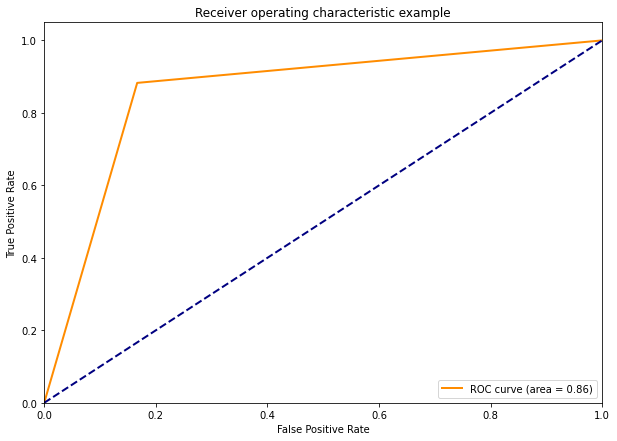

In [10]:
# Courbe ROC et AUC
plot_roc(y_test, y_pred)

sources :
http://ethen8181.github.io/machine-learning/keras/text_classification/word2vec_text_classification.html

In [11]:
k = 10
# kfold = StratifiedKFold(n_splits=k, random_state=None, shuffle=True) #n_splits = k de la k-fold cv, le nombre de fold
kfold = RepeatedStratifiedKFold(n_splits=k, n_repeats=2, random_state=None)
scoring = 'accuracy'
cv_param = kfold
num_experiences = 10
train_sizes = np.linspace(0.1, 1.0, num_experiences)
# train_sizes = np.linspace(0.001, 1.0, num_experiences)
n_jobs = -1

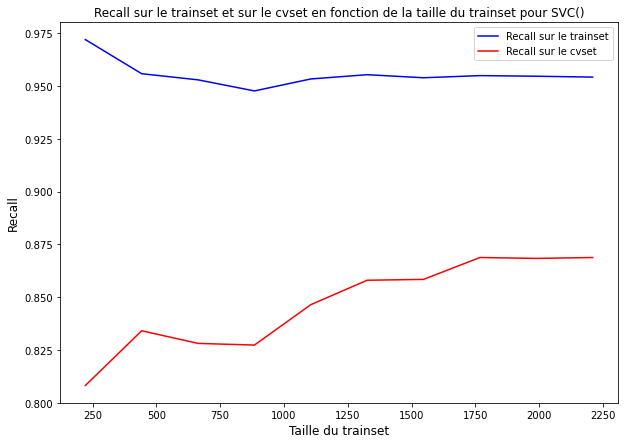

In [12]:
model = SVC() #le meilleur modele garde apres cross validation 
get_learning_curve(model, X_train, y_train, cv_param, "recall", train_sizes, n_jobs)

In [13]:
get_learning_curve(model, X_train, y_train, cv_param, "accuracy", train_sizes, n_jobs)

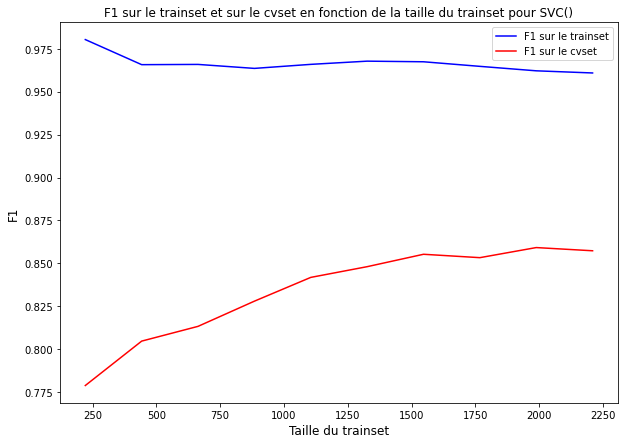

In [14]:
get_learning_curve(model, X_train, y_train, cv_param, "f1", train_sizes, n_jobs)

In [15]:
get_learning_curve(model, X_train, y_train, cv_param, "f1_macro", train_sizes, n_jobs)

In [16]:
get_learning_curve(model, X_train, y_train, cv_param, "precision", train_sizes, n_jobs)

In [17]:
# On affiche les documents a propos desquels le modele s'est trompe
corpus_test = pd.DataFrame({"id":corpus.iloc[indices_test].id, "message": corpus.iloc[indices_test].message, "truth":y_test, "pred":y_pred})
corpus_test_errors = corpus_test.query("truth != pred")
print(corpus_test.shape)
print(corpus_test_errors.shape)
# corpus_test_errors = corpus_test_errors[["truth", "pred", "message_preprocessed"]]
print(corpus_test_errors.columns)
corpus_test_errors = corpus_test_errors[["id", "truth", "pred", "message"]]
# corpus_test_errors

(1210, 4)
(173, 4)
Index(['id', 'message', 'truth', 'pred'], dtype='object')


In [18]:
with pd.option_context("display.max_rows", 1000):
    display(corpus.iloc[corpus_test_errors[corpus_test_errors["pred"] == 1].id]) 

id  \
3187  3187   
1657  1657   
2496  2496   
1626  1626   
599    599   
3469  3469   
408    408   
2292  2292   
3363  3363   
3449  3449   
1800  1800   
1612  1612   
196    196   
3043  3043   
1491  1491   
2619  2619   
776    776   
410    410   
2894  2894   
2714  2714   
1582  1582   
1068  1068   
1298  1298   
1461  1461   
2962  2962   
238    238   
457    457   
3509  3509   
2413  2413   
551    551   
1475  1475   
1483  1483   
240    240   
3551  3551   
256    256   
1616  1616   
761    761   
2978  2978   
324    324   
221    221   
2538  2538   
3300  3300   
1618  1618   
1278  1278   
1222  1222   
423    423   
1113  1113   
3375  3375   
1894  1894   
1537  1537   
2099  2099   
2016  2016   
3480  3480   
1064  1064   
3006  3006   
1580  1580   
978    978   
3259  3259   
3477  3477   
3044  3044   
3531  3531   
25      25   
3172  3172   
1370  1370   
2144  2144   
1742  1742   
370    370   
729    729   
1221  1221   
2377  2377   
2140  2140   
1691  1691   
1601  1601   
2736  2736   
2218  2218   
1956  1956   
742    742   
985    985   
3274  3274   
812    812   
3467  3467   
318    318   
1425  1425   
3660  3660   
2163  2163   
3273  3273   
69      69   
2053  2053   
1132  1132   
135    135   
22      22   
887    887   
272    272   
3165  3165   
2885  2885   
498    498   
2987  2987   
1814  1814   
1494  1494   
3626  3626   
2720  2720   
1356  1356   
1729  1729   
212    212   
819    819   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     message  \
3187                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 R√©fl√©chissons √† cela : va-t-on dire √† son enfant qu‚Äôil doit pard

In [19]:
with pd.option_context("display.max_rows", 1000):
    display(corpus.iloc[corpus_test_errors[corpus_test_errors["pred"] == 0].id])

id  \
2498  2498   
1825  1825   
1395  1395   
2823  2823   
718    718   
26      26   
450    450   
3215  3215   
2867  2867   
463    463   
1744  1744   
2227  2227   
1175  1175   
3216  3216   
2606  2606   
1732  1732   
746    746   
2620  2620   
2313  2313   
2653  2653   
102    102   
1067  1067   
58      58   
2113  2113   
432    432   
1954  1954   
1926  1926   
178    178   
430    430   
3442  3442   
764    764   
682    682   
3173  3173   
744    744   
1094  1094   
2677  2677   
3542  3542   
2597  2597   
2876  2876   
3320  3320   
2155  2155   
596    596   
2483  2483   
1138  1138   
2835  2835   
3481  3481   
2364  2364   
1569  1569   
227    227   
1071  1071   
1702  1702   
1188  1188   
2928  2928   
2236  2236   
1075  1075   
2037  2037   
108    108   
2281  2281   
697    697   
1539  1539   
1820  1820   
460    460   
1089  1089   
1876  1876   
2587  2587   
2800  2800   
2215  2215   
2351  2351   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               message  \
2498                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Le style d‚Äô√©criture de Van Til et son utilisation idiosyncrasique d‚Äôune terminologie philosophique obscure ne sont pas les seuls obstacles faisant face √† une √©valuation attentive et critique de sa pens√©e. D‚Äôautres obstacles sont apparus en raison du d√©bat qui perdure sur l‚Äôenseignement de Van Til. Certains Van Tilliens, par exemple, pensent que les critiques de Van Til n‚Äôont jamais vraiment compris Van Til. John Frame, par exemple, dit que les critiques de Van Til ¬´ semblent toujours passer √† c√¥t√© de ce qui est √©vident6. ¬ª Cela est vrai dans une certaine mesure, et signifie que les d√©fenseurs de la pens√©e de Van Til ont d√ª passer beaucoup de temps √† corriger des interpr√©tations erron√©es7.   
1825                                                                                                                                                                                                              